In [1]:
import copy
import random
from collections import defaultdict
from dataclasses import dataclass, field
from typing import Tuple, Optional, Literal, Union, Dict, NamedTuple, List

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from IPython.display import clear_output
from tqdm.auto import trange

In [2]:
class State(NamedTuple):
    board_hash: str
    empty_spaces: List[Tuple[int, int]]
    cur_turn: Literal[-1, 1]

In [3]:
class Qtable(dict):
    def __init__(self, n_rows=3, n_cols=3):
        super().__init__()
        self.n_rows = n_rows
        self.n_cols = n_cols

    def __missing__(self, key):
        item = np.zeros((self.n_rows, self.n_cols))
        self[key] = np.where(np.array(list(key)).reshape(self.n_rows, self.n_cols) == '1', item, -10)
        return self[key]

Класс TicTacToe немного отличается от данного в материалах лекции - get_empty_spaces возвращает список кортежей, и добавлен метод set_state для удобства при реализации MCTS.

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.game_over = False
        self.board_hash = None
        # ход первого игрока
        self.cur_turn = 1
        self.empty_spaces = None

        self.reset()

    def get_empty_spaces(self):
        if self.empty_spaces is None:
            res = np.where(self.board == 0)
            self.empty_spaces = list(zip(res[0], res[1]))
        return self.empty_spaces

    def make_move(self, player, i, j):
        self.board[i, j] = player
        self.empty_spaces = None
        self.board_hash = None

    def get_hash(self):
        if self.board_hash is None:
            self.board_hash = ''.join(['%s' % (x + 1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.board_hash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False

    def is_terminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.cur_turn)
        if cur_win:
                self.game_over = True
                return self.cur_turn

        if len(self.get_empty_spaces()) == 0:
            self.game_over = True
            return 0

        self.game_over = False
        return None

    def get_winner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.get_empty_spaces()) == 0:
            return 0
        return None

    def print_board(self):
        for i in range(0, self.n_rows):
            print('----' * self.n_cols + '-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                elif self.board[i, j] == -1:
                    token = 'o'
                else:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----' * self.n_cols + '-')

    def get_state(self):
        return State(self.get_hash(), self.get_empty_spaces(), self.cur_turn)

    def set_state(self, state: State):
        self.board = np.array(list(state.board_hash), dtype=int).reshape(self.n_rows, self.n_cols) - 1
        self.cur_turn = state.cur_turn
        self.empty_spaces = None
        self.board_hash = None

    def action_from_int(self, action_int):
        return int(action_int / self.n_cols), int(action_int % self.n_cols)

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.get_state(), -10, True, False, {}
        self.make_move(self.cur_turn, action[0], action[1])
        reward = self.is_terminal()
        self.cur_turn = -self.cur_turn
        return self.get_state(), 0 if reward is None else reward, reward is not None, False, {}

    def reset(self, *, seed=None, options=None):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.board_hash = None
        self.game_over = False
        self.empty_spaces = None
        self.cur_turn = 1
        return self.get_state(), {}

In [5]:
def get_random_action(state: State) -> Tuple[int, int]:
    return random.choice(state.empty_spaces)

In [6]:
class Strategy:
    def get_action(self, env: TicTacToe):
        raise NotImplementedError

In [7]:
class QStrategy(Strategy):
    def reset(self):
        pass

    def get_eps_greedy_action(self, state: State, eps: float):
        raise NotImplementedError

    def get_action(self, env: TicTacToe):
        return self.get_eps_greedy_action(env.get_state(), 0)

    def update(self,
               old_state: State,
               new_state: Optional[State],
               action: Tuple[int, int],
               reward: float,
               is_done: bool):
        pass

In [8]:
class RandomStrategy(QStrategy):
    def get_eps_greedy_action(self, state: State, eps=0):
        return get_random_action(state)

In [9]:
def simulate_game(env: TicTacToe, x_policy: Strategy, o_policy: Strategy, print_steps=True):
    state, _ = env.reset()
    is_done = False
    while not is_done:
        if state.cur_turn == 1:
            action = x_policy.get_action(env)
        else:
            action = o_policy.get_action(env)
        state, reward, is_done, _, _ = env.step(action)
        if print_steps:
            env.print_board()
    return reward

In [10]:
def eval_policy(env: TicTacToe, policy: Strategy):
    print("Average reward for X: ", np.mean([simulate_game(env, policy, RandomStrategy(), print_steps=False) for _ in range(1_000)]))
    print("Average reward for O: ", np.mean([-simulate_game(env, RandomStrategy(), policy, print_steps=False) for _ in range(1_000)]))

# Часть нулевая. Доски и результаты случайных стратегий на них.

Доска 3х3

In [11]:
env3x3 = TicTacToe()
print("Average reward for X: ", np.mean([simulate_game(env3x3, RandomStrategy(), RandomStrategy(), print_steps=False) for _ in range(1_000)]))

Average reward for X:  0.338


Доска 4х4

In [12]:
env4x4 = TicTacToe(4, 4, 4)
print("Average reward for X: ", np.mean([simulate_game(env4x4, RandomStrategy(), RandomStrategy(), print_steps=False) for _ in range(1_000)]))

Average reward for X:  0.037


Доска 5х5

In [13]:
env5x5 = TicTacToe(5, 5, 5)
print("Average reward for X: ", np.mean([simulate_game(env5x5, RandomStrategy(), RandomStrategy(), print_steps=False) for _ in range(1_000)]))

Average reward for X:  0.087


# Часть первая. Q-learning

## 1. Доска 3х3

In [14]:
class TabularQStrategy(QStrategy):
    def __init__(self, n_rows=3, n_cols=3, *, alpha=0.1, gamma=0.8):
        self.Q = Qtable(n_rows=n_rows, n_cols=n_cols)
        self.alpha = alpha
        self.gamma = gamma

    def reset(self):
        self.Q.clear()

    def get_eps_greedy_action(self,
                              state: State,
                              eps: float = 0.05) -> Tuple[int, int]:
        if np.random.rand() < eps:
            return get_random_action(state)
        else:
            return np.unravel_index(np.argmax(self.Q[state.board_hash]), self.Q[state.board_hash].shape)

    def update(self,
               old_state: State,
               new_state: Optional[State],
               action: Tuple[int, int],
               reward: float,
               is_done: bool):
        reward *= old_state.cur_turn
        self.Q[old_state.board_hash][action] += self.alpha * (reward - self.Q[old_state.board_hash][action])
        if not is_done:  # No need to init Q-values for terminal states
            self.Q[old_state.board_hash][action] += self.alpha * self.gamma * np.max(self.Q[new_state.board_hash])

In [15]:
def q_learning(
        env: gym.Env,
        policy: QStrategy,
        max_games: int = 1_000_000,
        continue_training: bool = False,
        eps: float = 0.05,
        eps_decay: float = 1.,
        eps_min: float = 0.05,
        warmup: int = 0,
        patience: int = 30_000,
        average_on: int = 10_000,
        plot_every: int = 1_000
):
    if not continue_training:
        policy.reset()

    rewards_buff_x = np.zeros(average_on) - np.inf
    rewards_buff_o = np.zeros(average_on) - np.inf
    best_avg_x = -np.inf
    best_avg_o = -np.inf
    since_last_improvement = 0
    avg_rewards_x = []
    avg_rewards_o = []

    x_games = o_games = 0

    for iteration in range(max_games):

        state, _ = env.reset()
        is_done = False
        prev_state = prev_action = None
        reward = 0

        player_mark = np.random.choice([-1, 1])  # Randomly choose to play Xs or Os

        while not is_done:
            if state.cur_turn == player_mark:
                action = policy.get_eps_greedy_action(state, eps)
            else:
                action = get_random_action(state)
            prev_prev_state = prev_state
            prev_state = state
            state, reward, is_done, _, _ = env.step(action)
            if (prev_prev_state is not None) and (reward > -10):
                policy.update(prev_prev_state, state, prev_action, reward, is_done)
            if is_done:
                policy.update(prev_state, state, action, reward, is_done)
            prev_action = action

        eps = max(eps_min, eps * eps_decay)

        if player_mark == 1:
            rewards_buff_x[x_games % average_on] = reward
            x_games += 1
            avg_reward = np.mean(rewards_buff_x)
        else:
            rewards_buff_o[o_games % average_on] = reward * -1 if reward > -10 else reward
            o_games += 1
            avg_reward = np.mean(rewards_buff_o)

        if iteration > warmup:
            if (player_mark == 1) and (avg_reward > best_avg_x):
                since_last_improvement = 0
                best_avg_x = avg_reward
            elif (player_mark == -1) and (avg_reward > best_avg_o):
                since_last_improvement = 0
                best_avg_o = avg_reward
            else:
                since_last_improvement += 1
                if since_last_improvement > patience:
                    print(f"Converged after {iteration + 1} games with average score {avg_rewards_x[-1]:.2f} for Xs and {avg_rewards_o[-1]:.2f} for Os!")
                    return

        if (iteration + 1) % plot_every == 0:
            avg_rewards_x.append(np.mean(rewards_buff_x) if x_games > average_on else np.mean(rewards_buff_x[:x_games]))
            avg_rewards_o.append(np.mean(rewards_buff_o) if o_games > average_on else np.mean(rewards_buff_o[:o_games]))

            clear_output(wait=True)
            plt.plot(np.arange(plot_every, iteration + 1 + 1, plot_every), avg_rewards_x, label="X")
            plt.plot(np.arange(plot_every, iteration + 1 + 1, plot_every), avg_rewards_o, label="O")
            plt.xlabel("# games")
            plt.ylabel("Avg. reward")
            plt.legend()
            plt.show()
    print(f"Did not converge after {max_games} games.")

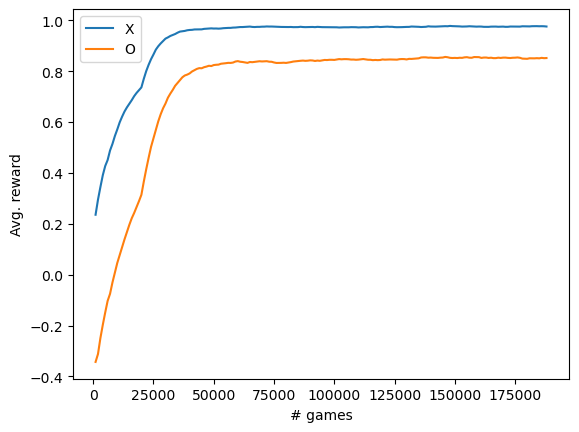

Converged after 188495 games with average score 0.98 for Xs and 0.85 for Os!
Average reward for X:  0.992
Average reward for O:  0.926


In [16]:
policy3x3_tabular = TabularQStrategy()
q_learning(env3x3, policy3x3_tabular, eps=1.0, eps_decay=0.9999)
eval_policy(env3x3, policy3x3_tabular)

## 2. Доски 4х4 и 5х5

### Доска 4х4

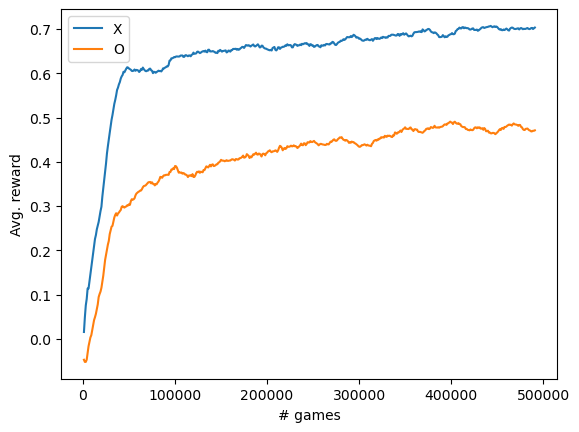

Converged after 491443 games with average score 0.70 for Xs and 0.47 for Os!
Average reward for X:  0.784
Average reward for O:  0.513


In [17]:
policy4x4_tabular = TabularQStrategy(4, 4, gamma=0.9)
q_learning(env4x4, policy4x4_tabular, eps=1.0, eps_decay=0.9999, patience=50_000)
eval_policy(env4x4, policy4x4_tabular)

### Доска 5х5

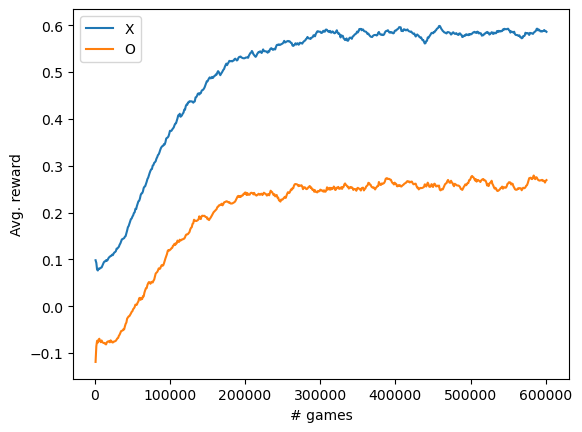

Converged after 601596 games with average score 0.59 for Xs and 0.27 for Os!
Average reward for X:  0.585
Average reward for O:  0.334


In [18]:
policy5x5_tabular = TabularQStrategy(5, 5, gamma=0.99)
q_learning(env5x5, policy5x5_tabular, eps=1.0, eps_decay=0.99999, patience=100_000)
eval_policy(env5x5, policy5x5_tabular)

# Часть вторая. Нейросети

## 3. DQN

Идея выбранной архитектуры нейросети в том, чтобы одна обученная сеть могла играть на досках разного размера при условии, что длина выигрышной последовательности остается той же.
Для этого размер ядра свертки, кажется, должен быть таким, чтобы от центра в любую сторону целиком влезала выигрышная последовательность, т.е. $(n_{wins} - 1) * 2 + 1 = 2*n_{wins}-1$.

In [19]:
class RotatingConv2d(nn.Conv2d):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.mean(torch.stack([self._conv_forward(input, torch.rot90(self.weight, k, dims=[-2, -1]), self.bias) for k in range(4)]), dim=0)

In [20]:
class DQN(nn.Module):
    def __init__(self, kernel_size=3, hidden_size=10):
        super().__init__()
        self.conv = RotatingConv2d(kernel_size=kernel_size, in_channels=2, out_channels=hidden_size)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.out_proj = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.leaky_relu(x)
        x = x.transpose(-3, -2).transpose(-2, -1)
        x = self.fc(x)
        x = nn.functional.leaky_relu(x)
        x = self.out_proj(x)
        return x.squeeze(-1)

In [21]:
TransitionsBatch = Tuple[torch.FloatTensor, torch.LongTensor, torch.FloatTensor, torch.FloatTensor, torch.BoolTensor]

In [22]:
class ReplayBuffer:
    def __init__(self, max_size=10_000, device='cpu'):
        self.size = max_size
        self.n_stored = 0
        self.next_idx = 0
        self.device = device

        self.state = None
        self.action = None
        self.next_state = None
        self.reward = None
        self.done = None

    def is_samplable(self, replay_size):
        return replay_size <= self.n_stored

    def store(self, state: torch.Tensor, action: Tuple[int, int], next_state: torch.Tensor, reward: float, is_done: bool):
        if self.state is None:
            self.state = torch.empty([self.size] + list(state.shape), dtype=torch.float32, device=self.device)
            self.action = torch.empty([self.size, 2], dtype=torch.long, device=self.device)
            self.next_state = torch.empty([self.size] + list(state.shape), dtype=torch.float32, device=self.device)
            self.reward = torch.empty(self.size, dtype=torch.float32, device=self.device)
            self.done = torch.empty(self.size, dtype=torch.bool, device=self.device)
        self.state[self.next_idx] = state
        self.action[self.next_idx] = torch.tensor(action, dtype=torch.long, device=self.device)
        self.next_state[self.next_idx] = next_state
        self.reward[self.next_idx] = reward
        self.done[self.next_idx] = is_done

        self.next_idx = (self.next_idx + 1) % self.size
        self.n_stored = min(self.size, self.n_stored + 1)

    def get_sample(self, replay_size: int) -> TransitionsBatch:
        idxes = torch.randperm(self.n_stored)[:replay_size]
        return self.state[idxes], self.action[idxes], self.next_state[idxes], self.reward[idxes], self.done[idxes]

In [23]:
class DQNStrategyBase(QStrategy):
    replay_buffers: Dict[int, ReplayBuffer]
    models: Dict[int, DQN]
    optimizers: Dict[int, torch.optim.Optimizer]

    def __init__(self,
                 n_rows: int = 3, n_cols: int = 3,
                 kernel_size: int = 3, hidden_size: int = 10,
                 learning_rate: float = 0.05, batch_size: int = 64,
                 replay_buffer_size: int = 10_000,
                 gamma: float = 0.9,
                 device: Union[torch.device, str] = 'cpu'):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.kernel_size = kernel_size
        self.device = device
        self.replay_buffer_size = replay_buffer_size
        self.lr = learning_rate
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.gamma = gamma

        self.game_counter = 0

        self.criterion = nn.MSELoss()
        self.reset()

    def reset(self):
        raise NotImplementedError

    def prepare_obs(self, state):
        obs_np = np.array(list(state.board_hash), dtype=np.float32).reshape((self.n_rows, self.n_cols)) - 1
        pad_mask = np.pad(np.zeros_like(obs_np), self.kernel_size // 2, constant_values=1.)
        obs_np = np.pad(obs_np, self.kernel_size // 2)
        obs_np = np.stack([obs_np, pad_mask])
        return torch.tensor(obs_np).to(self.device)

    def get_eps_greedy_action(self, state: State, eps: float):
        if np.random.rand() < eps:
                return get_random_action(state)
        else:
            with torch.no_grad():
                obs = self.prepare_obs(state)
                model_output = self.models[state.cur_turn](obs)
            model_output = torch.where(obs[0, self.kernel_size // 2 : -(self.kernel_size // 2), self.kernel_size // 2 : -(self.kernel_size // 2)] == 0,
                                       model_output,
                                       -10)
            argmax = torch.argmax(model_output).item()
            return np.unravel_index(argmax, (self.n_rows, self.n_cols))

    def update(self,
               old_state: State,
               new_state: Optional[State],
               action: Tuple[int, int],
               reward: float,
               is_done: bool):
        reward = reward * old_state.cur_turn
        old_obs = self.prepare_obs(old_state)
        new_obs = self.prepare_obs(new_state)
        self.replay_buffers[old_state.cur_turn].store(old_obs, action, new_obs, reward, is_done)
        if is_done and self.replay_buffers[old_state.cur_turn].is_samplable(self.batch_size):
            self.replay(old_state.cur_turn, self.replay_buffers[old_state.cur_turn].get_sample(self.batch_size))
        if is_done:
            self.game_counter += 1

    def replay(self, agent: Literal[-1, 1], batch: TransitionsBatch):
        raise NotImplementedError

In [24]:
class SimpleDQNStrategy(DQNStrategyBase):
    def reset(self):
        self.replay_buffers = {
            -1: ReplayBuffer(max_size=self.replay_buffer_size, device=self.device),
            1: ReplayBuffer(max_size=self.replay_buffer_size, device=self.device)
        }
        self.models = {
            -1: DQN(kernel_size=self.kernel_size, hidden_size=self.hidden_size).to(self.device),
            1: DQN(kernel_size=self.kernel_size, hidden_size=self.hidden_size).to(self.device)
        }
        self.optimizers = {key: torch.optim.AdamW(self.models[key].parameters(), lr=self.lr, weight_decay=1e-5) for key in self.models}

    def replay(self, agent: Literal[-1, 1], batch: TransitionsBatch):
        states, actions, next_states, rewards, done_mask = batch
        q_values_next = torch.zeros((states.shape[0], self.n_rows, self.n_cols), device=self.device)
        with torch.no_grad():
            if not torch.all(done_mask):
                q_values_next[~done_mask] = self.models[agent](next_states[~done_mask])
        q_values_actions = rewards + q_values_next.amax((1, 2)) * self.gamma

        self.optimizers[agent].zero_grad()
        preds = self.models[agent](states)
        loss = self.criterion(preds[(slice(None), actions[:, 0], actions[:, 1])].diag(), q_values_actions)
        loss.backward()
        self.optimizers[agent].step()

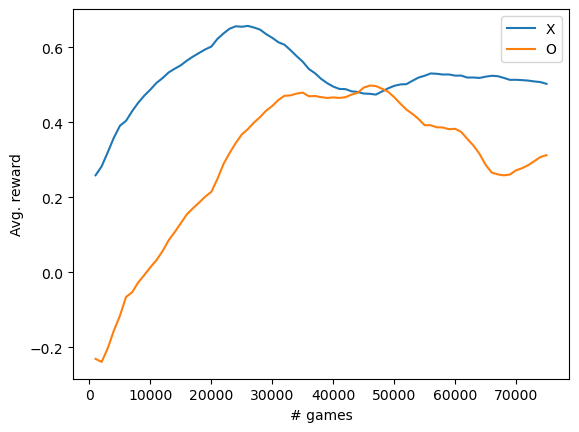

Converged after 75650 games with average score 0.50 for Xs and 0.31 for Os!
Average reward for X:  0.462
Average reward for O:  0.253


In [25]:
dqn_policy_3x3 = SimpleDQNStrategy(device="cuda", hidden_size=16, kernel_size=5, batch_size=128, learning_rate=1e-4)
q_learning(env3x3, dqn_policy_3x3, eps=1.0, eps_decay=0.9999)
eval_policy(env3x3, dqn_policy_3x3)

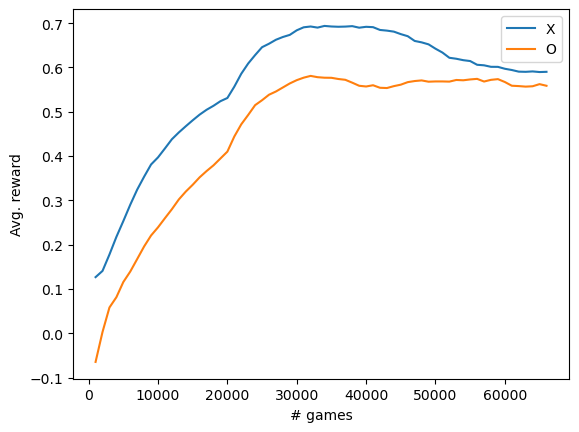

Converged after 66494 games with average score 0.59 for Xs and 0.56 for Os!
Average reward for X:  0.603
Average reward for O:  0.537


In [26]:
dqn_policy_4x4 = SimpleDQNStrategy(n_rows=4, n_cols=4, device="cuda", hidden_size=16, kernel_size=7, batch_size=128, learning_rate=1e-4)
q_learning(env4x4, dqn_policy_4x4, eps=1.0, eps_decay=0.9999)
eval_policy(env4x4, dqn_policy_4x4)

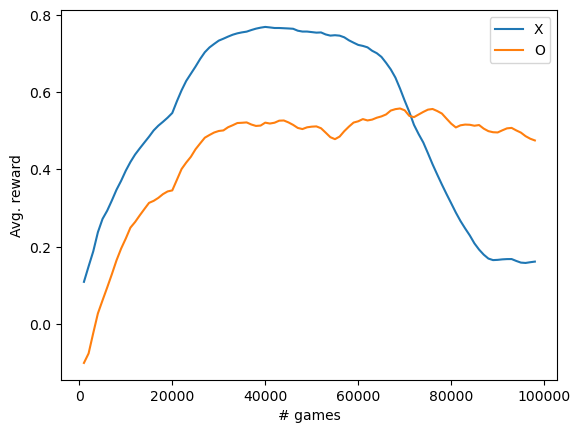

Converged after 98934 games with average score 0.16 for Xs and 0.48 for Os!
Average reward for X:  0.106
Average reward for O:  0.379


In [27]:
dqn_policy_5x5 = SimpleDQNStrategy(n_rows=5, n_cols=5, device="cuda", hidden_size=16, kernel_size=9, batch_size=128, learning_rate=1e-4)
q_learning(env5x5, dqn_policy_5x5, eps=1.0, eps_decay=0.9999)
eval_policy(env5x5, dqn_policy_5x5)

## 4. DoubleDQN

In [28]:
class DoubleDQNStrategy(DQNStrategyBase):
    target_models: Dict[int, DQN]

    def __init__(self,
                 *args,
                 target_update_every: int = 1000,
                 **kwargs):
        self.target_update_every = target_update_every
        super().__init__(*args, **kwargs)

    def reset(self):
        self.replay_buffers = {
            -1: ReplayBuffer(max_size=self.replay_buffer_size, device=self.device),
            1: ReplayBuffer(max_size=self.replay_buffer_size, device=self.device)
        }
        self.models = {
            -1: DQN(kernel_size=self.kernel_size, hidden_size=self.hidden_size).to(self.device),
            1: DQN(kernel_size=self.kernel_size, hidden_size=self.hidden_size).to(self.device)
        }
        self.target_models = {
            -1: DQN(kernel_size=self.kernel_size, hidden_size=self.hidden_size).to(self.device),
            1: DQN(kernel_size=self.kernel_size, hidden_size=self.hidden_size).to(self.device)
        }
        self.update_target()
        self.optimizers = {key: torch.optim.AdamW(self.models[key].parameters(), lr=self.lr, weight_decay=1e-5) for key in self.models}

    def update_target(self):
        for key in self.models:
            self.target_models[key].load_state_dict(self.models[key].state_dict())

    def update(self, *args, **kwargs):
        super().update(*args, **kwargs)
        if self.game_counter % self.target_update_every == 0:
            self.update_target()

    def replay(self, agent: Literal[-1, 1], batch: TransitionsBatch):
        states, actions, next_states, rewards, done_mask = batch
        q_values_next = torch.zeros((states.shape[0], self.n_rows, self.n_cols), device=self.device)
        with torch.no_grad():
            if not torch.all(done_mask):
                q_values_next[~done_mask] = self.target_models[agent](next_states[~done_mask])
        q_values_actions = rewards + q_values_next.amax((1, 2)) * self.gamma

        self.optimizers[agent].zero_grad()
        preds = self.models[agent](states)
        loss = self.criterion(preds[(slice(None), actions[:, 0], actions[:, 1])].diag(), q_values_actions)
        loss.backward()
        self.optimizers[agent].step()

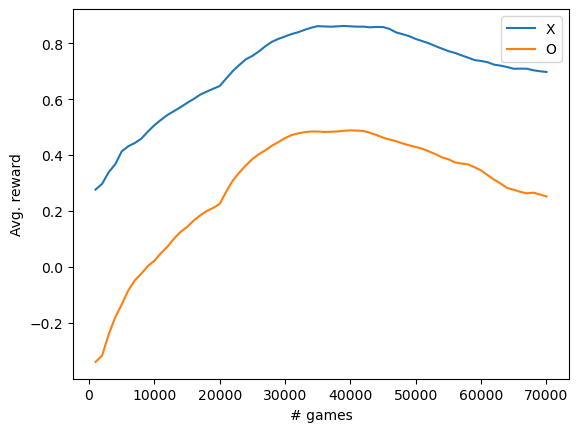

Converged after 70590 games with average score 0.70 for Xs and 0.25 for Os!
Average reward for X:  0.647
Average reward for O:  0.194


In [29]:
ddqn_policy_3x3 = DoubleDQNStrategy(device="cuda", hidden_size=16, kernel_size=5, batch_size=128, learning_rate=1e-4, target_update_every=100)
q_learning(env3x3, ddqn_policy_3x3, eps=1.0, eps_decay=0.9999)
eval_policy(env3x3, ddqn_policy_3x3)

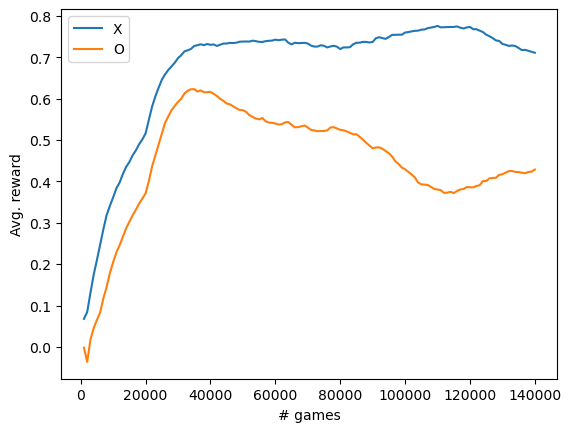

Converged after 140033 games with average score 0.71 for Xs and 0.43 for Os!
Average reward for X:  0.774
Average reward for O:  0.514


In [30]:
ddqn_policy_4x4 = DoubleDQNStrategy(n_rows=4, n_cols=4, device="cuda", hidden_size=16, kernel_size=7, batch_size=128, learning_rate=1e-4, target_update_every=100)
q_learning(env4x4, ddqn_policy_4x4, eps=1.0, eps_decay=0.9999)
eval_policy(env4x4, ddqn_policy_4x4)

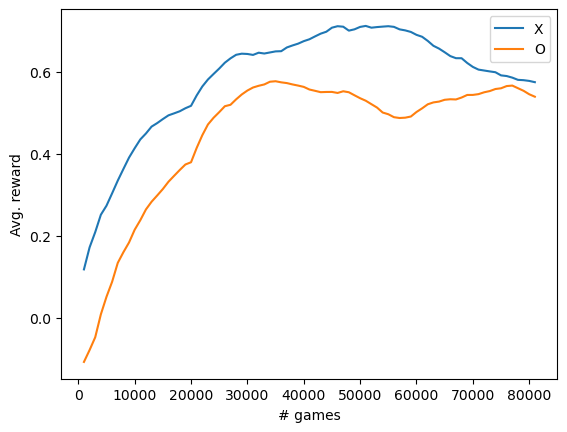

Converged after 81194 games with average score 0.57 for Xs and 0.54 for Os!
Average reward for X:  0.629
Average reward for O:  0.483


In [31]:
ddqn_policy_5x5 = DoubleDQNStrategy(n_rows=5, n_cols=5, device="cuda", hidden_size=16, kernel_size=9, batch_size=128, learning_rate=1e-4, target_update_every=100)
q_learning(env5x5, ddqn_policy_5x5, eps=1.0, eps_decay=0.9999)
eval_policy(env5x5, ddqn_policy_5x5)

# Часть третья. MCTS

## 5. MCTS

In [32]:
@dataclass
class MCTSNode:
    n: int = 0
    w: float = 0
    children: "List[Tuple[int, int], MCTSNode]" = field(default_factory=list)
    not_tried_actions: List[Tuple[int, int]] = field(default_factory=list)

In [33]:
class MCTSStrategy(Strategy):
    node_dict: Dict[str, MCTSNode]
    env: TicTacToe

    def __init__(self, n_iter: int = 1_000, rollout_strategy: Strategy = RandomStrategy()):
        self.n_iter = n_iter
        self.rollout_strategy = rollout_strategy

    def reset(self):
        self.node_dict = defaultdict(MCTSNode)

    def _choose_and_act(self, node, uct_c=np.sqrt(2)):
        if node.not_tried_actions:
            action = node.not_tried_actions.pop()
            state, reward, is_done, _, _ = self.env.step(action)
            child = self.node_dict[state.board_hash]
            node.children.append((action, child))
            node.n += child.n
            node.w += child.n - child.w
        else:
            max_weight = -1
            chosen_action = None
            for action, child in node.children:
                if (weight := child.w / child.n + uct_c * np.sqrt(np.log(node.n) / child.n)) > max_weight:
                    max_weight = weight
                    chosen_action = action
            state, reward, is_done, _, _ = self.env.step(chosen_action)
        return state, reward, is_done

    def _do_rollout(self):
        is_done = False
        while not is_done:
            state, reward, is_done, _, _ = self.env.step(self.rollout_strategy.get_action(self.env))
        return reward

    @staticmethod
    def _reward2w(reward: int, state: State):
        return (-state.cur_turn * reward + 1) / 2

    def search_one_episode(self, parent_node=None):
        if parent_node is None:
            state = self.env.get_state()
            reward = 0
            is_done = False
        else:
            state, reward, is_done = self._choose_and_act(parent_node)
        cur_node = self.node_dict[state.board_hash]
        cur_node.n += 1
        if not is_done:
            if cur_node.n == 1:
                cur_node.not_tried_actions = state.empty_spaces
                reward = self._do_rollout()
            else:
                reward = self.search_one_episode(cur_node)
        cur_node.w += self._reward2w(reward, state)
        return reward

    def get_action(self, env: TicTacToe):
        self.reset()
        self.env = copy.deepcopy(env)
        for _ in range(self.n_iter):
            self.env.set_state(env.get_state())
            self.search_one_episode()
        max_weight = -1
        chosen_action = None
        for action, child in self.node_dict[env.get_hash()].children:
            if (weight := child.w / child.n) > max_weight:
                max_weight = weight
                chosen_action = action
        return chosen_action

In [34]:
mcts_policy_100 = MCTSStrategy(100, rollout_strategy=RandomStrategy())

In [35]:
%%time
eval_policy(env3x3, mcts_policy_100)

Average reward for X:  0.984
Average reward for O:  0.849
CPU times: user 1min 52s, sys: 3.51 ms, total: 1min 52s
Wall time: 1min 52s


In [36]:
%%time
eval_policy(env4x4, mcts_policy_100)

Average reward for X:  0.923
Average reward for O:  0.842
CPU times: user 6min 55s, sys: 46.1 ms, total: 6min 56s
Wall time: 6min 55s


In [37]:
%%time
eval_policy(env5x5, mcts_policy_100)

Average reward for X:  0.854
Average reward for O:  0.791
CPU times: user 20min 25s, sys: 143 ms, total: 20min 25s
Wall time: 20min 25s


In [38]:
mcts_policy_1000 = MCTSStrategy(1000, rollout_strategy=RandomStrategy())

In [39]:
%%time
eval_policy(env3x3, mcts_policy_1000)

Average reward for X:  0.983
Average reward for O:  0.917
CPU times: user 19min 40s, sys: 84.8 ms, total: 19min 40s
Wall time: 19min 39s
